# Example 5: Multi-state FBR-SOP tutorial (LVC model)

| run type      | wavefunction | backend | Basis  | steps |
| ---           | ---          | ---     | ---    | ---   |
| propagation | MPS-SM | JAX   | HO-DVR+Exciton | 200    |


## 1. Import modules

In [1]:
import numpy as np
from discvar import HarmonicOscillator as HO

from pytdscf import (
    BasInfo,
    Exciton,
    Model,
    Simulator,
    TensorHamiltonian,
    TensorOperator,
    construct_kinetic_operator,
    construct_nMR_recursive,
)
from pytdscf.units import au_in_cm1

## 2. Define basis funciton
In this case, 2-state 3-mode simulation of N=10, ω1=1500 cm-1, ω2=2000 cm-1, ω3=2500 cm-1 are defined

In [2]:
freqs_cm1 = [2000, 1000]
omega2_au = [(freq / au_in_cm1) ** 2 for freq in freqs_cm1]
nprim = 9
basis = [HO(nprim, freq) for freq in freqs_cm1]
basinfo = BasInfo([basis, basis])
omega2_au

[8.304076374771499e-05, 2.0760190936928748e-05]

## 3. Define Hamiltonian
In this case, Hamiltonian is defined by
$$
H=\left[\begin{array}{cc}
-\Delta E/2 + \sum_v\left(-\frac{\partial^2}{\partial Q_v^2}+ \frac{\omega_v^2}{2}Q_v^2 \right) & J_{12} + \sum_v \lambda_{12}^{(v)} Q_v\\
J_{21}  + \sum_v \lambda_{21}^{(v)} Q_v& \sum_v\left(-\frac{\partial^2}{\partial Q_v^2}+ \frac{\omega_v^2}{2}Q_v^2 + \kappa Q_v \right)+\Delta E/2
\end{array}\right].
$$

In [3]:
coupleJ = 0.0001  # J_12 and J_21 in a.u.
deltaE = 0.00  # ΔE in a.u.
lam = 0.001
kappa = 0.001
backend = "jax"

In [4]:
s0_func = {}
s1_func = {}
v01_func = {}

for i in range(len(omega2_au)):
    # print(i, ω2)
    s0_func[(i,)] = lambda Qi, i=i: omega2_au[i] / 2 * (Qi**2)  # late binding
    s1_func[(i,)] = lambda Qi, i=i: kappa * Qi + omega2_au[i] / 2 * Qi**2
    v01_func[(i,)] = lambda Qi, i=i: lam * Qi

In [5]:
mpo_11 = construct_nMR_recursive(basis, nMR=1, func=s1_func, rate=0.99999999999)
mpo_00 = construct_nMR_recursive(basis, nMR=1, func=s0_func, rate=0.99999999999)
mpo_01 = construct_nMR_recursive(
    basis, nMR=1, func=v01_func, rate=0.99999999999
)

In [6]:
V11 = {tuple([k for k in range(len(basis))]): TensorOperator(mpo=mpo_11)}
V00 = {tuple([k for k in range(len(basis))]): TensorOperator(mpo=mpo_00)}
V01 = {tuple([k for k in range(len(basis))]): TensorOperator(mpo=mpo_01)}

_coupleJ = [
    [-deltaE / 2, coupleJ],
    [coupleJ, deltaE / 2],
]

V11[()] = _coupleJ[1][1]
V00[()] = _coupleJ[0][0]
V01[()] = _coupleJ[0][1]

potential = [[V00, V01], [V01, V11]]

K00 = construct_kinetic_operator(basis)
kinetic = [[K00, None], [None, K00]]

H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=kinetic, backend=backend
)

operators = {"hamiltonian": H}

## 4. Define misc
- MPS bond-dimension is m=4
- Initial population of 1-state is 1.0
- Initial vibrational state is $|0,0,0\rangle \otimes |1,0,0\rangle$ (only S0 state 0-th mode is excited)

In [7]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = 20
model.init_weight_ESTATE = [0.0, 1.0]
model.init_HartreeProduct = [
    [ho.get_unitary()[0].tolist() for ho in basis],
    [ho.get_unitary()[0].tolist() for ho in basis],
]

## 5. Execute simulation
- Δt=0.1 fs
- If `proj_gs=True`, then the initial vibrational state is projected from `model.primbas_gs`.

In [8]:
jobname = "DVR-Exciton"
simulator = Simulator(jobname, model, backend=backend, proj_gs=False)
simulator.propagate(maxstep=10, stepsize=0.1, thresh_sil=1.0e-09)

2024-11-28 22:53:39,674 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-11-28 22:53:39,674 - INFO:main.pytdscf._const_cls - Log file is ./DVR-Exciton_prop/main.log
2024-11-28 22:53:39,675 - INFO:main.pytdscf.simulator_cls - Set integral of DVR basis
2024-11-28 22:53:39,676 - INFO:main.pytdscf.simulator_cls - Set initial wave function (DVR basis)
2024-11-28 22:53:39,676 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2024-11-28 22:53:39,676 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 0.0
2024-11-28 22:53:39,676 - INFO:main.pytdscf._mps_cls - Initial MPS: 1-state with weights 1.0
2024-11-28 22:53:39,754 - INFO:main.pytdscf.simulator_cls - Wave function is saved in wf_DVR-Exciton.pkl
2024-11-28 22:53:39,

(0.006834502878971094, <pytdscf.wavefunction.WFunc at 0x1223ae990>)

In [9]:
!cat DVR-Exciton_prop/populations.dat

# time [fs]	pop_0      	pop_1      
0.000000000	0.000000000	1.000000000	
0.100000000	0.002803416	0.997196584	
0.200000000	0.011094224	0.988905776	
0.300000000	0.024522727	0.975477273	
0.400000000	0.042533942	0.957466058	
0.500000000	0.064406385	0.935593615	
0.600000000	0.089300791	0.910699209	
0.700000000	0.116314102	0.883685898	
0.800000000	0.144533828	0.855466172	
0.900000000	0.173088218	0.826911782	


/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid, fd = os.forkpty()


## 7. Visualize populations

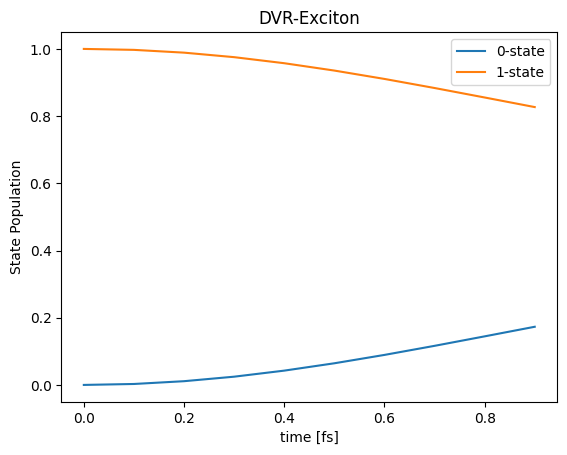

In [10]:
# !gnuplot -e " set xlabel 'time [fs]'; set ylabel 'population'; plot 'PropagateMultiStateSOP/populations.log' using 1:2 with lines title '0-state', 'PropagateMultiStateSOP/populations.log' using 1:3 with lines title '1-state'"
import matplotlib.pyplot as plt

data = np.loadtxt("DVR-Exciton_prop/populations.dat")

plt.plot(data[:, 0], data[:, 1], label="0-state")
plt.plot(data[:, 0], data[:, 2], label="1-state")

plt.title(jobname)
plt.xlabel("time [fs]")
plt.ylabel("State Population")

plt.legend()
plt.show()

In [11]:
import sympy
from pympo import AssignManager, OpSite, SumOfProducts
from pympo.operators import get_eye_site

In [12]:
basis = [Exciton(nstate=2)] + [HO(nprim, freq) for freq in freqs_cm1]
ndim = len(basis)

In [13]:
lam = sympy.Symbol("lambda")
kappa = sympy.Symbol("kappa")
ΔE = sympy.Symbol(r"\Delta E")
J = sympy.Symbol("J")
omega2s = [None] + [sympy.Symbol("omega^2" + f"_{i}") for i in range(1, ndim)]

q_scale = 10.0

subs = {ΔE: deltaE, J: coupleJ, lam: 0.001 * q_scale, kappa: 0.001 * q_scale}
for omega2_val, omega2_sym in zip(omega2_au, omega2s[1:], strict=True):
    subs[omega2_sym] = omega2_val * (q_scale**2)
subs

{\Delta E: 0.0,
 J: 0.0001,
 lambda: 0.01,
 kappa: 0.01,
 omega^2_1: 0.008304076374771499,
 omega^2_2: 0.0020760190936928748}

ΔE = deltaE
J = coupleJ
lam =  0.001
kappa =  0.001
omega2s = [None] + omega2_au
subs = {}

In [14]:
q1_list = [None] + [np.array(ho.get_grids()) / q_scale for ho in basis[1:]]
q2_list = [None] + [q1**2 for q1 in q1_list[1:]]
p2_list = [None] + [ho.get_2nd_derivative_matrix_dvr() for ho in basis[1:]]
a = basis[0].get_annihilation_matrix()
adag = basis[0].get_creation_matrix()
a_dim = 0

p2_ops = [None] + [
    OpSite(r"\hat{p}^2" + f"_{i}", i, value=p2_list[i]) for i in range(1, ndim)
]
q2_ops = [None] + [
    OpSite(r"\hat{q}^2" + f"_{i}", i, value=q2_list[i]) for i in range(1, ndim)
]
q1_ops = [None] + [
    OpSite(r"\hat{q}" + f"_{i}", i, value=q1_list[i]) for i in range(1, ndim)
]
a_ops = [OpSite(r"\hat{a}" + f"_{0}", 0, value=a)] + [None] * 2
adag_ops = [OpSite(r"\hat{a}^\dagger" + f"_{0}", 0, value=adag)] + [None] * 2
eye = get_eye_site(a_dim, n_basis=2)

In [15]:
pot = SumOfProducts()
a_dim = 0  # estate-mode
b_dim = set([0, 1, 2]) - set([a_dim])  # bath-mode
for i in b_dim:
    pot += 0.5 * omega2s[i] * adag_ops[a_dim] * a_ops[a_dim] * q2_ops[i]
    pot += 0.5 * omega2s[i] * a_ops[a_dim] * adag_ops[a_dim] * q2_ops[i]
    pot += kappa * adag_ops[a_dim] * a_ops[a_dim] * q1_ops[i]
    pot += lam * q1_ops[i] * a_ops[a_dim]
    pot += lam * q1_ops[i] * adag_ops[a_dim]

pot += ΔE / 2 * adag_ops[a_dim] * a_ops[a_dim]
pot += -ΔE / 2 * a_ops[a_dim] * adag_ops[a_dim]
pot += J * (adag_ops[a_dim] + a_ops[a_dim])


pot = pot.simplify()  # This method find concatenatable operator in advance like q_i*a_j + q_i*a†_j = q_i * (a_j+a†_j)
display(pot.symbol)

J*(\hat{a}^\dagger_0 + \hat{a}_0) + \Delta E*\hat{a}^\dagger_0*\hat{a}_0/2 - \Delta E*\hat{a}_0*\hat{a}^\dagger_0/2 + kappa*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}_1 + kappa*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}_2 + lambda*(\hat{a}^\dagger_0 + \hat{a}_0)*\hat{q}_1 + lambda*(\hat{a}^\dagger_0 + \hat{a}_0)*\hat{q}_2 + 0.5*omega^2_1*(\hat{a}^\dagger_0*\hat{a}_0 + \hat{a}_0*\hat{a}^\dagger_0)*\hat{q}^2_1 + 0.5*omega^2_2*(\hat{a}^\dagger_0*\hat{a}_0 + \hat{a}_0*\hat{a}^\dagger_0)*\hat{q}^2_2

In [16]:
am = AssignManager(pot)
display(*am.Wsym)

Matrix([[\hat{a}^\dagger_0*\hat{a}_0 + \hat{a}_0*\hat{a}^\dagger_0, \hat{a}^\dagger_0*\hat{a}_0, \hat{a}^\dagger_0 + \hat{a}_0, \hat{a}^\dagger_0*\hat{a}_0 + \hat{a}_0*\hat{a}^\dagger_0, \hat{a}^\dagger_0*\hat{a}_0, \hat{a}^\dagger_0 + \hat{a}_0, \hat{a}^\dagger_0*\hat{a}_0, \hat{a}_0*\hat{a}^\dagger_0, \hat{a}^\dagger_0 + \hat{a}_0]])

Matrix([
[\hat{q}^2_1,         0,         0, 0, 0, 0, 0, 0, 0],
[          0, \hat{q}_1,         0, 0, 0, 0, 0, 0, 0],
[          0,         0, \hat{q}_1, 0, 0, 0, 0, 0, 0],
[          0,         0,         0, 1, 0, 0, 0, 0, 0],
[          0,         0,         0, 0, 1, 0, 0, 0, 0],
[          0,         0,         0, 0, 0, 1, 0, 0, 0],
[          0,         0,         0, 0, 0, 0, 1, 0, 0],
[          0,         0,         0, 0, 0, 0, 0, 1, 0],
[          0,         0,         0, 0, 0, 0, 0, 0, 1]])

Matrix([
[            0.5*omega^2_1],
[                    kappa],
[                   lambda],
[0.5*omega^2_2*\hat{q}^2_2],
[          kappa*\hat{q}_2],
[         lambda*\hat{q}_2],
[               \Delta E/2],
[              -\Delta E/2],
[                        J]])

In [17]:
W_prod = sympy.Mul(*am.Wsym)
print(*[f"W{i}" for i in range(am.ndim)], "=")
display(W_prod[0].expand())

W0 W1 W2 =


J*\hat{a}^\dagger_0 + J*\hat{a}_0 + \Delta E*\hat{a}^\dagger_0*\hat{a}_0/2 - \Delta E*\hat{a}_0*\hat{a}^\dagger_0/2 + kappa*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}_1 + kappa*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}_2 + lambda*\hat{a}^\dagger_0*\hat{q}_1 + lambda*\hat{a}^\dagger_0*\hat{q}_2 + lambda*\hat{a}_0*\hat{q}_1 + lambda*\hat{a}_0*\hat{q}_2 + 0.5*omega^2_1*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}^2_1 + 0.5*omega^2_1*\hat{a}_0*\hat{a}^\dagger_0*\hat{q}^2_1 + 0.5*omega^2_2*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}^2_2 + 0.5*omega^2_2*\hat{a}_0*\hat{a}^\dagger_0*\hat{q}^2_2

In [18]:
am.assign()
display(*am.Wsym)
W_prod = sympy.Mul(*am.Wsym)
print(*[f"W{i}" for i in range(am.ndim)], "=")
display(W_prod[0].expand())
display(pot.symbol.expand())
display((W_prod[0].expand() - pot.symbol.expand()).simplify())
# assert W_prod[0].expand() == pot.symbol.expand()

2024-11-28 22:53:41.763 | INFO     | pympo.bipartite:assign:256 - assigned isite=0/3
2024-11-28 22:53:41.764 | INFO     | pympo.bipartite:assign:256 - assigned isite=1/3
2024-11-28 22:53:41.766 | INFO     | pympo.bipartite:assign:256 - assigned isite=2/3


Matrix([[\hat{a}^\dagger_0 + \hat{a}_0, \hat{a}^\dagger_0*\hat{a}_0 + \hat{a}_0*\hat{a}^\dagger_0, \hat{a}_0*\hat{a}^\dagger_0, \hat{a}^\dagger_0*\hat{a}_0]])

Matrix([
[            0, lambda,         J + lambda*\hat{q}_1],
[0.5*omega^2_2,      0,    0.5*omega^2_1*\hat{q}^2_1],
[            0,      0,                  -\Delta E/2],
[            0,  kappa, \Delta E/2 + kappa*\hat{q}_1]])

Matrix([
[\hat{q}^2_2],
[  \hat{q}_2],
[          1]])

W0 W1 W2 =


J*\hat{a}^\dagger_0 + J*\hat{a}_0 + \Delta E*\hat{a}^\dagger_0*\hat{a}_0/2 - \Delta E*\hat{a}_0*\hat{a}^\dagger_0/2 + kappa*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}_1 + kappa*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}_2 + lambda*\hat{a}^\dagger_0*\hat{q}_1 + lambda*\hat{a}^\dagger_0*\hat{q}_2 + lambda*\hat{a}_0*\hat{q}_1 + lambda*\hat{a}_0*\hat{q}_2 + 0.5*omega^2_1*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}^2_1 + 0.5*omega^2_1*\hat{a}_0*\hat{a}^\dagger_0*\hat{q}^2_1 + 0.5*omega^2_2*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}^2_2 + 0.5*omega^2_2*\hat{a}_0*\hat{a}^\dagger_0*\hat{q}^2_2

J*\hat{a}^\dagger_0 + J*\hat{a}_0 + \Delta E*\hat{a}^\dagger_0*\hat{a}_0/2 - \Delta E*\hat{a}_0*\hat{a}^\dagger_0/2 + kappa*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}_1 + kappa*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}_2 + lambda*\hat{a}^\dagger_0*\hat{q}_1 + lambda*\hat{a}^\dagger_0*\hat{q}_2 + lambda*\hat{a}_0*\hat{q}_1 + lambda*\hat{a}_0*\hat{q}_2 + 0.5*omega^2_1*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}^2_1 + 0.5*omega^2_1*\hat{a}_0*\hat{a}^\dagger_0*\hat{q}^2_1 + 0.5*omega^2_2*\hat{a}^\dagger_0*\hat{a}_0*\hat{q}^2_2 + 0.5*omega^2_2*\hat{a}_0*\hat{a}^\dagger_0*\hat{q}^2_2

0

In [19]:
potential_mpo = am.numerical_mpo(subs=subs)

In [20]:
print(potential_mpo[1])
print(q1_list[1])
print(q2_list[1][3] * omega2s[1] / 2 - deltaE / 2)

[[[ 0.00000000e+00+0.j  1.00000000e-02+0.j -3.33274344e-02+0.j]
  [ 0.00000000e+00+0.j  1.00000000e-02+0.j -2.36436964e-02+0.j]
  [ 0.00000000e+00+0.j  1.00000000e-02+0.j -1.52839152e-02+0.j]
  [ 0.00000000e+00+0.j  1.00000000e-02+0.j -7.47960067e-03+0.j]
  [ 0.00000000e+00+0.j  1.00000000e-02+0.j  1.00000000e-04+0.j]
  [ 0.00000000e+00+0.j  1.00000000e-02+0.j  7.67960067e-03+0.j]
  [ 0.00000000e+00+0.j  1.00000000e-02+0.j  1.54839152e-02+0.j]
  [ 0.00000000e+00+0.j  1.00000000e-02+0.j  2.38436964e-02+0.j]
  [ 0.00000000e+00+0.j  1.00000000e-02+0.j  3.35274344e-02+0.j]]

 [[ 1.03800955e-03+0.j  0.00000000e+00+0.j  4.63945995e-02+0.j]
  [ 1.03800955e-03+0.j  0.00000000e+00+0.j  2.34076600e-02+0.j]
  [ 1.03800955e-03+0.j  0.00000000e+00+0.j  9.82641479e-03+0.j]
  [ 1.03800955e-03+0.j  0.00000000e+00+0.j  2.38536032e-03+0.j]
  [ 1.03800955e-03+0.j  0.00000000e+00+0.j  2.09624359e-33+0.j]
  [ 1.03800955e-03+0.j  0.00000000e+00+0.j  2.38536032e-03+0.j]
  [ 1.03800955e-03+0.j  0.00000000e+00

In [21]:
potential = [
    [{((0, 0), 1, 2): TensorOperator(mpo=potential_mpo, legs=(0, 0, 1, 2))}]
]

In [22]:
kin = SumOfProducts()
for i in b_dim:
    kin -= 1 / 2 * p2_ops[i] * eye  # * a_ops[a_dim] * adag_ops[a_dim] / 2
    # kin += 1 / 2 * p2_ops[i] * eye# * adag_ops[a_dim] * a_ops[a_dim] / 2
kin = kin.simplify()
kin.symbol

-0.5*\hat{1}_0*\hat{p}^2_1 - 0.5*\hat{1}_0*\hat{p}^2_2

In [23]:
am = AssignManager(kin)
am.assign()
display(*am.Wsym)
kinetic_mpo = am.numerical_mpo()

2024-11-28 22:53:41.871 | INFO     | pympo.bipartite:assign:256 - assigned isite=0/3
2024-11-28 22:53:41.872 | INFO     | pympo.bipartite:assign:256 - assigned isite=1/3
2024-11-28 22:53:41.873 | INFO     | pympo.bipartite:assign:256 - assigned isite=2/3


Matrix([[1]])

Matrix([[\hat{p}^2_1, 1]])

Matrix([
[            -0.5],
[-0.5*\hat{p}^2_2]])

In [24]:
kinetic = [
    [
        {
            (0, (1, 1), (2, 2)): TensorOperator(
                mpo=kinetic_mpo, legs=(0, 1, 1, 2, 2)
            )
        }
    ]
]
# kinetic = construct_kinetic_operator(basis[1:])

In [25]:
hamiltonian = TensorHamiltonian(
    ndof=3, potential=potential, kinetic=kinetic, backend=backend
)
operators = {"hamiltonian": hamiltonian}
basinfo = BasInfo([basis])
model = Model(basinfo, operators)
model.m_aux_max = 20
model.init_HartreeProduct = [
    [np.array([0.0, 1.0]).tolist()]
    + [ho.get_unitary()[0].tolist() for ho in basis[1:]]
]
# Starts from the S1 state
jobname = "DVR_Exciton2"
simulator = Simulator(jobname, model, backend=backend)
simulator.propagate(
    stepsize=0.1, maxstep=10, reduced_density=([(0, 0)], 1), thresh_sil=1.0e-09
)
# simulator.propagate(stepsize=0.1, maxstep=10, reduced_density=None, thresh_sil=1.e-07)

2024-11-28 22:53:41,912 - INFO:main.pytdscf.model_cls - The layer of SPF is not used.
2024-11-28 22:53:41,913 - WARNING:main.pytdscf._const_cls - rebind const jobname
2024-11-28 22:53:41,914 - WARNING:main.pytdscf._const_cls - rebind const logger
2024-11-28 22:53:41,914 - WARNING:main.pytdscf._const_cls - rebind const logger
2024-11-28 22:53:41,914 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-11-28 22:53:41,914 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-11-28 

(0.0068345028943889935, <pytdscf.wavefunction.WFunc at 0x13fe60410>)

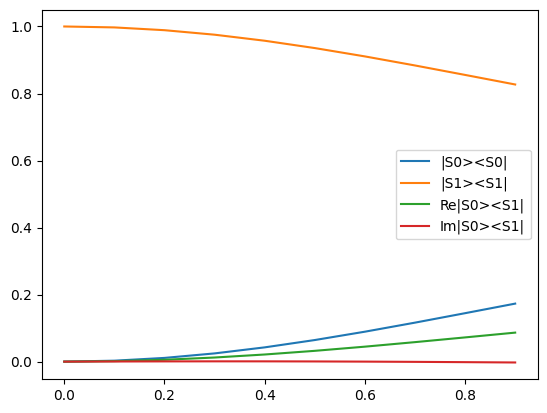

In [26]:
import netCDF4 as nc

with nc.Dataset(f"{jobname}_prop/reduced_density.nc", "r") as file:
    data = file.variables["rho_(0, 0)_0"][:]
    density_data_real = data["real"]
    density_data_imag = data["imag"]
    time_data = file.variables["time"][:]

plt.plot(time_data, density_data_real[:, 0, 0], label="|S0><S0|")
plt.plot(time_data, density_data_real[:, 1, 1], label="|S1><S1|")
plt.plot(time_data, density_data_real[:, 0, 1], label="Re|S0><S1|")
plt.plot(time_data, density_data_imag[:, 0, 1], label="Im|S0><S1|")
plt.legend()
plt.show()